In [96]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import math
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [97]:
# start = dt.datetime.today()-dt.timedelta(10000)
# end = dt.datetime.today()
stock = yf.Ticker("NVDA")

In [98]:
# df = yf.download(ticker, start, end)
df = stock.history(period="max")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-13,160.000000,163.119995,156.059998,156.470001,60415300.0,0.0,0.0
2022-06-14,157.309998,160.660004,154.119995,158.360001,46968000.0,0.0,0.0
2022-06-15,160.949997,168.679993,159.259995,165.270004,56393600.0,0.0,0.0
2022-06-16,158.600006,159.419998,154.009995,156.009995,54574900.0,0.0,0.0
2022-06-17,156.479996,159.949997,153.279999,158.800003,62905700.0,0.0,0.0


In [99]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = list(df.index)
    high = list(df['High'])
    low = list(df['Low'])
    close = list(df['Close'])
    psar = close[0:len(close)]
    psarbull = [None] * length # Bullish signal - dot below candle
    psarbear = [None] * length # Bearish signal - dot above candle
    bull = True
    af = iaf # acceleration factor
    ep = low[0] # ep = Extreme Point
    hp = high[0] # High Point
    lp = low[0] # Low Point

    # https://www.investopedia.com/terms/p/parabolicindicator.asp - Parabolic Stop & Reverse Formula from Investopedia 
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf
        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}

In [100]:
startidx = 0
endidx = len(df)
result = psar(df)
dates = result['dates'][startidx:endidx]
close = result['close'][startidx:endidx]
psar = result['psar'][startidx:endidx]
psarbear = result['psarbear'][startidx:endidx]
psarbull = result['psarbull'][startidx:endidx]
df['Slow MA'] = df['Close'].rolling(200).mean()

In [101]:
type(psar)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Slow MA
Date,,,,,,,,
1999-01-22,0.401739,0.448369,0.356304,0.376630,271468800.0,0.0,0.0,NaN
1999-01-25,0.406521,0.420869,0.376630,0.416086,51048000.0,0.0,0.0,NaN
1999-01-26,0.420869,0.429239,0.377825,0.383804,34320000.0,0.0,0.0,NaN
1999-01-27,0.385000,0.394565,0.363478,0.382609,24436800.0,0.0,0.0,NaN
1999-01-28,0.382609,0.385000,0.379021,0.381413,22752000.0,0.0,0.0,NaN


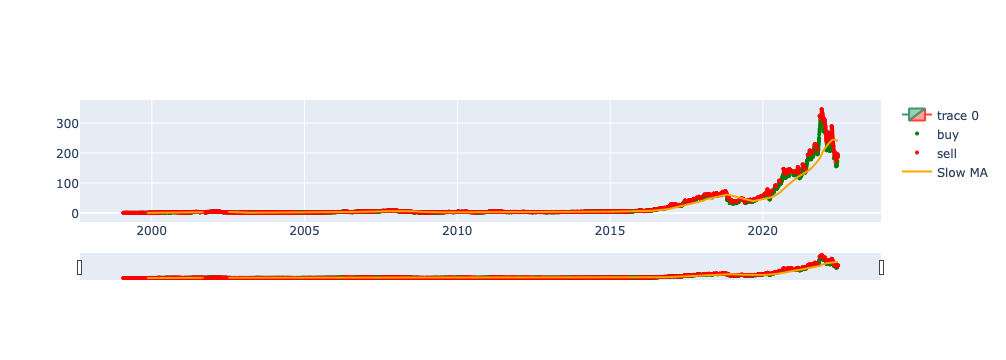

In [102]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.add_trace(go.Scatter(x=dates, y=psarbull, name='buy',mode = 'markers',
                         marker = dict(color='green', size=4)))

fig.add_trace(go.Scatter(x=dates, y=psarbear, name='sell', mode = 'markers',
                         marker = dict(color='red', size=4)))

fig.add_trace(go.Scatter(x=df.index, y=df['Slow MA'], name='Slow MA',
                         line = dict(color='orange', width=2)))

# fig.add_trace(go.Scatter(x=df.index, y=df['Fast MA'], name='fast MA',
#                           line = dict(color='Blue', width=2)))
#fig.show()

In [103]:
#import talib

In [104]:
# df['50 MA'], df['200 MA'] = talib.MA(df['Adj Close'], timeperiod=50, matype=0), talib.MA(df['Adj Close'], timeperiod=200, matype=0)
# df['9 MA'], df['21 MA'] = talib.MA(df['Adj Close'], timeperiod=9, matype=0), talib.MA(df['Adj Close'], timeperiod=21, matype=0)
#df['PSAR'] = real = talib.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)
df["PSAR"] = result['psar'][startidx:endidx]
# df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['Action'] = np.where(df['Close'] > df['Slow MA'] , 1, 0) 
df['Action'] = np.where(df['Close'] < df['Slow MA'], -1, df['Action'])
df['PSAR_Action'] = np.where(df['PSAR'] < df['Low'] , 1, 0) 
df['PSAR_Action'] = np.where(df['PSAR'] > df['High'], -1, df['PSAR_Action'])
df.dropna(inplace=True)

In [105]:
len(df)

5493

In [106]:
def signal(df):
    if df['Action'] == 1 and df['PSAR_Action'] == 1:
        return 1
    elif df['Action'] == -1 and df['PSAR_Action'] == -1:
        return -1
    else:
        return 0

In [107]:
df['signal'] = df.apply(signal, axis = 1)

In [108]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Slow MA,PSAR,Action,PSAR_Action,signal
Date,,,,,,,,,,,,
1999-11-04,0.530869,0.572717,0.530869,0.558369,126033600.0,0.0,0.0,0.392613,0.381271,1,1,1
1999-11-05,0.573912,0.578695,0.514130,0.540434,61636800.0,0.0,0.0,0.393432,0.396586,1,1,1
1999-11-08,0.523695,0.571521,0.506956,0.555978,47001600.0,0.0,0.0,0.394131,0.414797,1,1,1
1999-11-09,0.554782,0.557173,0.526087,0.547608,27235200.0,0.0,0.0,0.394950,0.431187,1,1,1
1999-11-10,0.549401,0.549999,0.532064,0.542826,14404800.0,0.0,0.0,0.395752,0.445938,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,160.000000,163.119995,156.059998,156.470001,60415300.0,0.0,0.0,240.948888,195.599362,-1,-1,-1
2022-06-14,157.309998,160.660004,154.119995,158.360001,46968000.0,0.0,0.0,240.609658,194.017788,-1,-1,-1
2022-06-15,160.949997,168.679993,159.259995,165.270004,56393600.0,0.0,0.0,240.302380,191.623920,-1,-1,-1


In [109]:
# fig1 = go.Figure(data=[go.Candlestick(x=df.index,
#                 open=df['Open'],
#                 high=df['High'],
#                 low=df['Low'],
#                 close=df['Close'])])

# fig1.add_trace(go.Scatter(x=dates, y=df['PSAR'], name='Parabolic Stop & Reverse (PSAR Signals)', mode = 'markers',
#                          marker = dict(color='black', size=4)))

# fig1.add_trace(go.Scatter(x=df.index, y=df['200 MA'], name='Slow MA',
#                          line = dict(color='orange', width=2)))

# fig1.add_trace(go.Scatter(x=df.index, y=df['50 MA'], name='fast MA',
#                          line = dict(color='Blue', width=2)))

# fig1.show()

In [136]:
# Create our features


# Shifting Signal to predict values from the previous day
##__________________ Work on shifitng only of Technical Indicators
df.dropna(inplace=True)
X_df = df.drop(columns=['signal',"Slow MA", "PSAR", "Action","PSAR_Action","Dividends","Stock Splits"])
#X = pd.get_dummies(X_df, columns=["Close","High","Low","Open","Slow MA","PSAR", "Action", "PSAR_Action"], drop_first = True)
#Slow MA PSAR Action PSAR_Action

# Create our target
y = df['PSAR'].to_frame()

In [118]:
#X.describe()
X_df.describe()

,Open,High,Low,Close,Volume
count,5493.000000,5493.000000,5493.000000,5493.000000,5.493000e+03
mean,27.447340,27.951715,26.894709,27.436235,6.068631e+07
std,55.345769,56.446893,54.081539,55.278964,4.192434e+07
min,0.523695,0.549999,0.506956,0.540434,4.564400e+06
25%,2.555057,2.630432,2.490780,2.550466,3.468240e+07
50%,3.999022,4.058709,3.930152,3.999021,5.160040e+07
75%,24.591357,24.852070,24.105450,24.506323,7.371480e+07
max,335.001042,346.295333,320.198497,333.591766,9.230856e+08


In [119]:
#X.describe()

In [120]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Slow MA,PSAR,Action,PSAR_Action,signal
Date,,,,,,,,,,,,
1999-11-04,0.530869,0.572717,0.530869,0.558369,126033600.0,0.0,0.0,0.392613,0.381271,1,1,1
1999-11-05,0.573912,0.578695,0.514130,0.540434,61636800.0,0.0,0.0,0.393432,0.396586,1,1,1
1999-11-08,0.523695,0.571521,0.506956,0.555978,47001600.0,0.0,0.0,0.394131,0.414797,1,1,1
1999-11-09,0.554782,0.557173,0.526087,0.547608,27235200.0,0.0,0.0,0.394950,0.431187,1,1,1
1999-11-10,0.549401,0.549999,0.532064,0.542826,14404800.0,0.0,0.0,0.395752,0.445938,1,1,1


In [121]:
X_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1999-11-04,0.530869,0.572717,0.530869,0.558369,126033600.0
1999-11-05,0.573912,0.578695,0.514130,0.540434,61636800.0
1999-11-08,0.523695,0.571521,0.506956,0.555978,47001600.0
1999-11-09,0.554782,0.557173,0.526087,0.547608,27235200.0
1999-11-10,0.549401,0.549999,0.532064,0.542826,14404800.0


In [122]:
len(X_df)

5493

In [123]:
y['PSAR'].value_counts()

1.595477      2
57.365694     2
5.106781      2
6.658900      2
1.119129      2
             ..
8.245981      1
8.258725      1
8.271728      1
8.284997      1
186.544590    1
Name: PSAR, Length: 5394, dtype: int64

In [124]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [125]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [126]:
t = X_df.index.max() - X_df.index.min()
(t * 0.70).days

5782

In [127]:
training_begin = X_df.index.min()

# Display the training begin date
print(training_begin)

1999-11-04 00:00:00


In [128]:
# Select the ending period for the training data with an offset of 3 months
training_end = X_df.index.min() + DateOffset(days= (t * 0.70).days )

# Display the training end date
print(training_end)

2015-09-03 00:00:00


In [129]:
# Generate the X_train and y_train DataFrames
X_train = X_df.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [130]:
# Generate the X_test and y_test DataFrames
X_test = X_df.loc[training_end:]
y_test = y.loc[training_end:]

In [131]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [132]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [133]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [134]:
# Resample the training data with the BalancedRandomForestClassifier
#from imblearn.ensemble import BalancedRandomForestClassifier
#brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

#PRODUCT BACKLOG: Develope and evaluate additioanl models


brf.fit(X_train, y_train)

/Users/satishsurath/opt/anaconda3/envs/dev3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



ValueError: Unknown label type: 'continuous'

In [89]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.3331166818825224

In [90]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[  0,   0, 148],
       [  3,  10, 654],
       [  3,  11, 881]])

In [91]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.00      0.00      1.00      0.00      0.00      0.00       148
          0       0.48      0.01      0.99      0.03      0.12      0.01       667
          1       0.52      0.98      0.02      0.68      0.13      0.02       895

avg / total       0.46      0.52      0.48      0.37      0.11      0.01      1710



In [92]:
pred_col = np.concatenate((y_test, pd.DataFrame(y_pred)), axis=0)

In [93]:
#df['Prediction'] = pred_col

In [94]:
len(df)

5493

In [95]:
len(pred_col)

3420